In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn
import torch.optim as optim
import warnings
import lstm
import data_prep
warnings.filterwarnings("ignore", category=UserWarning)

In [2]:
df = pd.read_csv('SolarPrediction.csv')
df

,UNIXTime,Data,Time,Radiation,Temperature,Pressure,Humidity,WindDirection(Degrees),Speed,TimeSunRise,TimeSunSet
0,1475229326,9/29/2016 12:00:00 AM,23:55:26,1.21,48,30.46,59,177.39,5.62,06:13:00,18:13:00
1,1475229023,9/29/2016 12:00:00 AM,23:50:23,1.21,48,30.46,58,176.78,3.37,06:13:00,18:13:00
2,1475228726,9/29/2016 12:00:00 AM,23:45:26,1.23,48,30.46,57,158.75,3.37,06:13:00,18:13:00
3,1475228421,9/29/2016 12:00:00 AM,23:40:21,1.21,48,30.46,60,137.71,3.37,06:13:00,18:13:00
4,1475228124,9/29/2016 12:00:00 AM,23:35:24,1.17,48,30.46,62,104.95,5.62,06:13:00,18:13:00
...,...,...,...,...,...,...,...,...,...,...,...
32681,1480587604,12/1/2016 12:00:00 AM,00:20:04,1.22,44,30.43,102,145.42,6.75,06:41:00,17:42:00
32682,1480587301,12/1/2016 12:00:00 AM,00:15:01,1.17,44,30.42,102,117.78,6.75,06:41:00,17:42:00
32683,1480587001,12/1/2016 12:00:00 AM,00:10:01,1.20,44,30.42,102,145.19,9.00,06:41:00,17:42:00
32684,1480586702,12/1/2016 12:00:00 AM,00:05:02,1.23,44,30.42,101,164.19,7.87,06:41:00,17:42:00


In [3]:
#get max value of Radiation
max_radiation = df['Radiation'].max()
print(max_radiation)
#get min value of Radiation
min_radiation = df['Radiation'].min()
print(min_radiation)


1601.26
1.11


In [4]:


# Rename 'Data' column to 'DateTime' for clarity
df = df.rename(columns={'Data': 'DateTime'})

# Convert DateTime to pandas datetime
df['DateTime'] = pd.to_datetime(df['DateTime'])

# Convert Time column to datetime.time objects for better handling
df['Time'] = pd.to_datetime(df['Time'], format='%H:%M:%S').dt.time

# Similarly, convert sunrise and sunset times
df['TimeSunRise'] = pd.to_datetime(df['TimeSunRise'], format='%H:%M:%S').dt.time
df['TimeSunSet'] = pd.to_datetime(df['TimeSunSet'], format='%H:%M:%S').dt.time

# Sort by DateTime to ensure proper plotting
df = df.sort_values('DateTime')
df

,UNIXTime,DateTime,Time,Radiation,Temperature,Pressure,Humidity,WindDirection(Degrees),Speed,TimeSunRise,TimeSunSet
7223,1472793006,2016-09-01,19:10:06,2.53,55,30.45,65,155.71,3.37,06:07:00,18:38:00
7257,1472781308,2016-09-01,15:55:08,628.80,63,30.42,58,1.55,6.75,06:07:00,18:38:00
7256,1472781606,2016-09-01,16:00:06,596.57,62,30.42,56,81.70,5.62,06:07:00,18:38:00
7255,1472781907,2016-09-01,16:05:07,577.10,62,30.42,57,53.61,7.87,06:07:00,18:38:00
7254,1472782211,2016-09-01,16:10:11,573.13,62,30.42,58,14.04,3.37,06:07:00,18:38:00
...,...,...,...,...,...,...,...,...,...,...,...
24714,1483206901,2016-12-31,07:55:01,39.30,43,30.31,86,262.51,5.62,06:57:00,17:54:00
24715,1483206602,2016-12-31,07:50:02,39.51,42,30.31,85,265.53,7.87,06:57:00,17:54:00
24716,1483206302,2016-12-31,07:45:02,52.87,42,30.31,84,240.48,4.50,06:57:00,17:54:00
24664,1483221902,2016-12-31,12:05:02,378.41,53,30.33,68,321.95,10.12,06:57:00,17:54:00


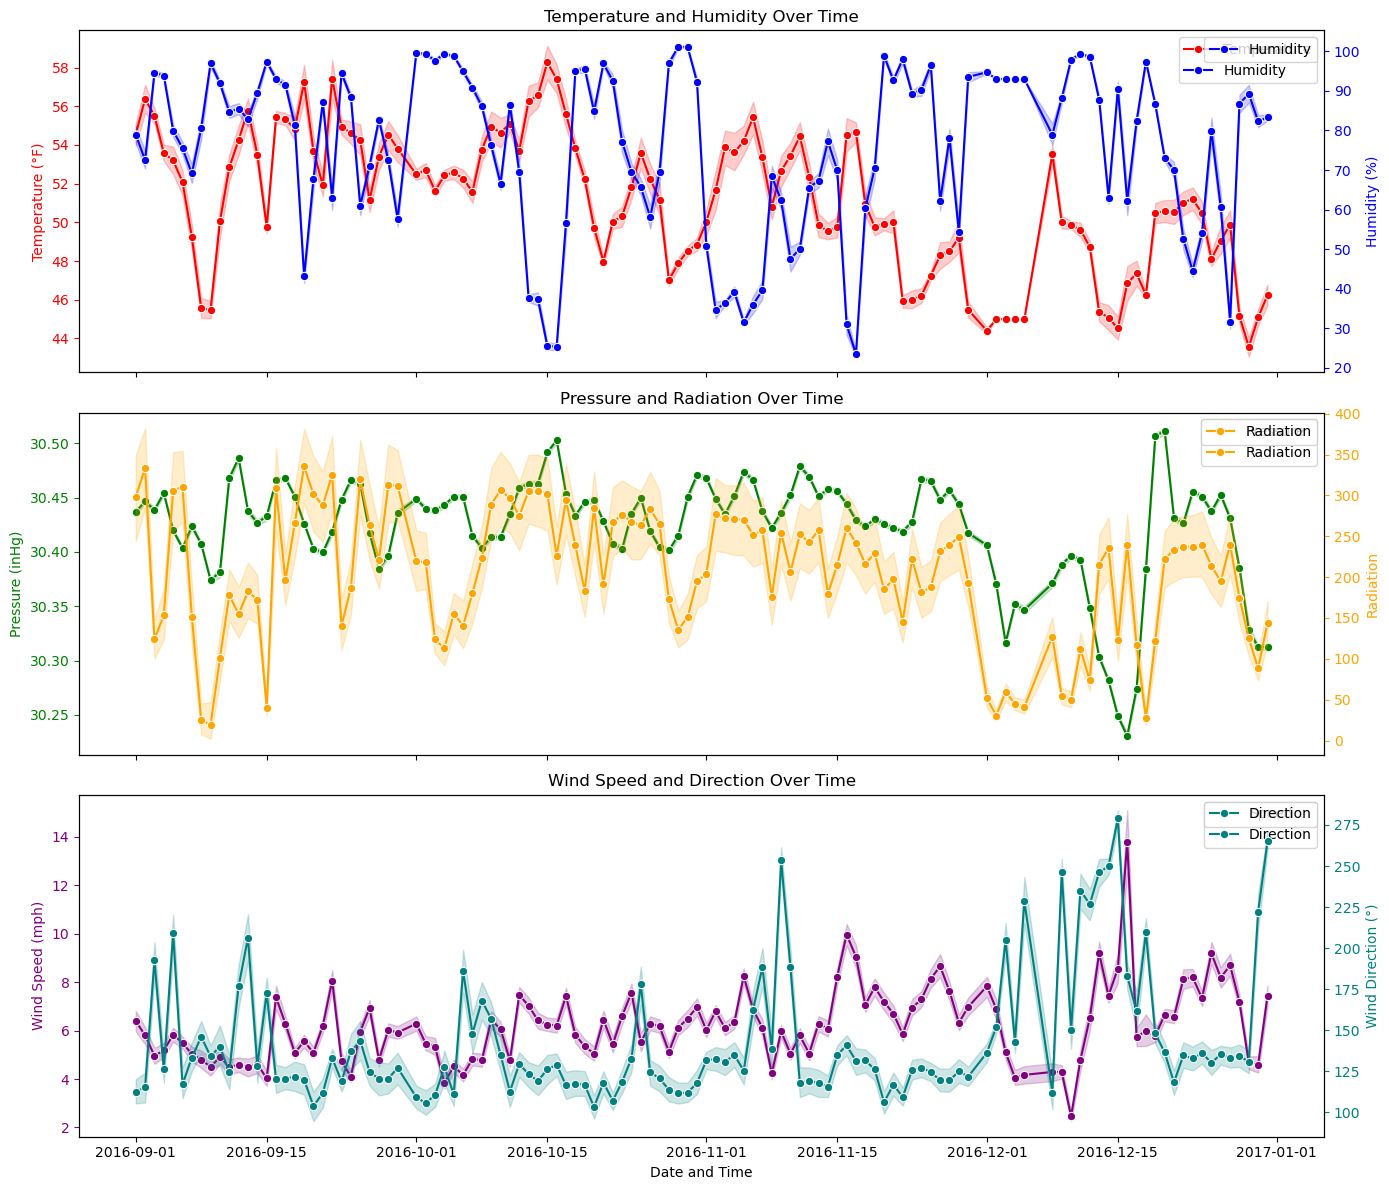

In [5]:

# Alternative visualization: Create a combined plot for related measurements
# Create a figure for related measurements (grouped by type)
fig, axes = plt.subplots(3, 1, figsize=(14, 12), sharex=True)

# Temperature and Humidity - often related
ax1 = axes[0]
ax1.set_title('Temperature and Humidity Over Time')
ax1_twin = ax1.twinx()  # Create a twin axis for Humidity

# Plot Temperature on left axis
sns.lineplot(x='DateTime', y='Temperature', data=df, marker='o', color='red', label='Temperature', ax=ax1)
ax1.set_ylabel('Temperature (°F)', color='red')
ax1.tick_params(axis='y', colors='red')

# Plot Humidity on right axis
sns.lineplot(x='DateTime', y='Humidity', data=df, marker='o', color='blue', label='Humidity', ax=ax1_twin)
ax1_twin.set_ylabel('Humidity (%)', color='blue')
ax1_twin.tick_params(axis='y', colors='blue')

# Add legend
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax1_twin.get_legend_handles_labels()
ax1.legend(lines1 + lines2, labels1 + labels2, loc='upper right')

# Pressure and Radiation
ax2 = axes[1]
ax2.set_title('Pressure and Radiation Over Time')
ax2_twin = ax2.twinx()  # Create a twin axis for Radiation

# Plot Pressure on left axis
sns.lineplot(x='DateTime', y='Pressure', data=df, marker='o', color='green', label='Pressure', ax=ax2)
ax2.set_ylabel('Pressure (inHg)', color='green')
ax2.tick_params(axis='y', colors='green')

# Plot Radiation on right axis
sns.lineplot(x='DateTime', y='Radiation', data=df, marker='o', color='orange', label='Radiation', ax=ax2_twin)
ax2_twin.set_ylabel('Radiation', color='orange')
ax2_twin.tick_params(axis='y', colors='orange')

# Add legend
lines1, labels1 = ax2.get_legend_handles_labels()
lines2, labels2 = ax2_twin.get_legend_handles_labels()
ax2.legend(lines1 + lines2, labels1 + labels2, loc='upper right')

# Wind Speed and Direction
ax3 = axes[2]
ax3.set_title('Wind Speed and Direction Over Time')
ax3_twin = ax3.twinx()  # Create a twin axis for Direction

# Plot Speed on left axis
sns.lineplot(x='DateTime', y='Speed', data=df, marker='o', color='purple', label='Speed', ax=ax3)
ax3.set_ylabel('Wind Speed (mph)', color='purple')
ax3.tick_params(axis='y', colors='purple')

# Plot Direction on right axis
sns.lineplot(x='DateTime', y='WindDirection(Degrees)', data=df, marker='o', color='teal', 
             label='Direction', ax=ax3_twin)
ax3_twin.set_ylabel('Wind Direction (°)', color='teal')
ax3_twin.tick_params(axis='y', colors='teal')

# Add legend
lines1, labels1 = ax3.get_legend_handles_labels()
lines2, labels2 = ax3_twin.get_legend_handles_labels()
ax3.legend(lines1 + lines2, labels1 + labels2, loc='upper right')

# Format the x-axis with appropriate date formatting for all subplots
plt.xticks(rotation=45)
ax3.set_xlabel('Date and Time')
plt.tight_layout()

plt.show()




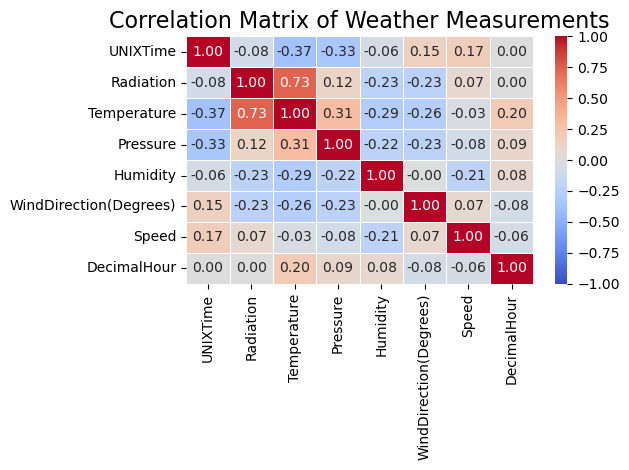

In [6]:
#plot correletions

df['Hour'] = pd.to_datetime(df['Time'], format='%H:%M:%S').dt.hour
df['Minute'] = pd.to_datetime(df['Time'], format='%H:%M:%S').dt.minute
# Create a decimal hour (hour + minute/60) for better correlation
df['DecimalHour'] = df['Hour'] + df['Minute']/60

# Select only numeric columns for correlation analysis
numeric_columns = ['UNIXTime', 'Radiation', 'Temperature', 'Pressure', 
                   'Humidity', 'WindDirection(Degrees)', 'Speed', 
                   'DecimalHour']
corr_df = df[numeric_columns]

# Calculate the correlation matrix
correlation_matrix = corr_df.corr()

# 1. Create a correlation heatmap
plt.figure()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1, 
            linewidths=0.5, fmt='.2f')
plt.title('Correlation Matrix of Weather Measurements', fontsize=16)
plt.tight_layout()
plt.savefig('correlation_heatmap.png', dpi=300, bbox_inches='tight')
plt.show()

## LSTM NN

In [7]:


target_col = 'Radiation'  # Column to predict


X_train, X_val, X_test, y_train, y_val, y_test, scalers, feature_cols, combined_transform_info, timestamps_train, timestamps_val, timestamps_test = data_prep.prepare_weather_data(
        df,     
        target_col='Radiation',  
        window_size=24,
        feature_selection_mode='basic',  # Start with basic features
        standardize_features=True,  # Try StandardScaler
        use_solar_elevation=True,  # Try the solar elevation feature
        use_piecewise_transform=False,  # Start without piecewise transform
        log_transform=True, #figured out this one is super important
        min_target_threshold=1.2
)


Adding solar elevation proxy feature
SolarElevation created for 32686 rows, 100.0% of data
Applying minimum threshold of 1.2 to Radiation
Found 1761 values below threshold (5.39% of data)
Added 'Radiation_is_low' feature (threshold: 1.2000)
Added SolarElevation to features
Using StandardScaler for feature scaling
X_train shape: (19596, 24, 17)
y_train shape: (19596, 1)
X_val shape: (6533, 24, 17)
y_val shape: (6533, 1)
X_test shape: (6533, 24, 17)
y_test shape: (6533, 1)
Features used: ['Radiation', 'Temperature', 'Pressure', 'Humidity', 'WindDirection(Degrees)', 'Speed', 'TimeMinutesSin', 'TimeMinutesCos', 'Radiation_is_low', 'SolarElevation', 'SunriseMinutes', 'SunsetMinutes', 'DaylightMinutes', 'TimeSinceSunrise', 'TimeUntilSunset', 'DaylightPosition', 'HourOfDay']


In [8]:
import optuna
import torch
import itertools
from sklearn.metrics import r2_score
device = torch.device('cpu')
#device = torch.device("mps")
def objective(trial):
    # Define hyperparameter space
    hidden_dim = trial.suggest_categorical('hidden_dim', [64, 128, 256])
    num_layers = trial.suggest_int('num_layers', 1, 3)
    dropout_prob = trial.suggest_float('dropout_prob', 0.1, 0.3, step=0.1)
    learning_rate = trial.suggest_float('learning_rate', 1e-4, 1e-3, log=True)
    clip_grad_norm = trial.suggest_categorical('clip_grad_norm', [1.0, 1.5])
    value_multiplier = trial.suggest_categorical('value_multiplier', [0.1, 0.15, 0.2])
    scheduler_type = trial.suggest_categorical('scheduler_type', ['plateau', 'cosine'])
    loss_type = trial.suggest_categorical('loss_type', ['mse', 'value_aware'])
    mse_weight = trial.suggest_categorical('mse_weight', [0.5, 0.7, 0.9])
    mape_weight = trial.suggest_categorical('mape_weight', [0.5, 0.3, 0.1])
    # Create model with trial parameters
    model = lstm.WeatherLSTM(
        input_dim=len(feature_cols),
        hidden_dim=hidden_dim,
        num_layers=num_layers,
        output_dim=1,
        dropout_prob=dropout_prob
    )
    
    # Train model
    model.fit(
        X_train, y_train, X_val, y_val,
        epochs=5,  # Just 5 epochs for initial screening
        batch_size=32,
        learning_rate=learning_rate,  # Use the suggested learning rate
        scheduler_type=scheduler_type,
        loss_type=loss_type,
        mse_weight=mse_weight,
        mape_weight=mape_weight,
        value_multiplier=value_multiplier,  # Use the suggested value multiplier
        clip_grad_norm=clip_grad_norm  # Use the suggested clip gradient norm
    )
    
    # Evaluate model
    model.eval()
    with torch.no_grad():
        predictions = model(torch.tensor(X_val, dtype=torch.float32).to(device))
        predictions = predictions.cpu().numpy()
    
    # Calculate metrics
    r2 = r2_score(y_val, predictions)
    print(f"Trial {trial.number}: hidden_dim={hidden_dim}, num_layers={num_layers}, "
          f"dropout_prob={dropout_prob}, learning_rate={learning_rate:.6f}, "
          f"clip_grad_norm={clip_grad_norm}, value_multiplier={value_multiplier}, R²={r2:.4f}")
    
    return r2  # Return metric to maximize



# Create study and optimize
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=20, n_jobs=-1)

# Get best parameters
best_params = study.best_params
print(f"Best parameters: {best_params}")
print(f"Best value (R²): {study.best_value:.4f}")

[I 2025-04-28 15:49:58,518] A new study created in memory with name: no-name-cd6fadd8-3d37-4bc4-b16a-3ee46a0aee54


X_train shape: (19596, 24, 17), y_train shape: (19596, 1)X_train shape: (19596, 24, 17), y_train shape: (19596, 1)
X_val shape: (6533, 24, 17), y_val shape: (6533, 1)

X_val shape: (6533, 24, 17), y_val shape: (6533, 1)
X_train shape: (19596, 24, 17), y_train shape: (19596, 1)
X_val shape: (6533, 24, 17), y_val shape: (6533, 1)
X_train shape: (19596, 24, 17), y_train shape: (19596, 1)
X_val shape: (6533, 24, 17), y_val shape: (6533, 1)
X_train shape: (19596, 24, 17), y_train shape: (19596, 1)
X_val shape: (6533, 24, 17), y_val shape: (6533, 1)
X_train shape: (19596, 24, 17), y_train shape: (19596, 1)
X_val shape: (6533, 24, 17), y_val shape: (6533, 1)
X_train shape: (19596, 24, 17), y_train shape: (19596, 1)
X_val shape: (6533, 24, 17), y_val shape: (6533, 1)
X_train shape: (19596, 24, 17), y_train shape: (19596, 1)
X_val shape: (6533, 24, 17), y_val shape: (6533, 1)
X_train shape: (19596, 24, 17), y_train shape: (19596, 1)
X_val shape: (6533, 24, 17), y_val shape: (6533, 1)
X_train sh

[I 2025-04-28 15:50:35,640] Trial 0 finished with value: 0.9696493292700133 and parameters: {'hidden_dim': 64, 'num_layers': 1, 'dropout_prob': 0.3, 'learning_rate': 0.0007376241063030161, 'clip_grad_norm': 1.0, 'value_multiplier': 0.1, 'scheduler_type': 'cosine', 'loss_type': 'value_aware', 'mse_weight': 0.9, 'mape_weight': 0.3}. Best is trial 0 with value: 0.9696493292700133.


Trial 0: hidden_dim=64, num_layers=1, dropout_prob=0.3, learning_rate=0.000738, clip_grad_norm=1.0, value_multiplier=0.1, R²=0.9696
X_train shape: (19596, 24, 17), y_train shape: (19596, 1)
X_val shape: (6533, 24, 17), y_val shape: (6533, 1)
Using Value-Aware Combined Loss (MSE weight: 0.5, MAPE weight: 0.1, value multiplier: 0.15)
Regularization settings:
- Dropout probability: 0.2
- L2 regularization (weight decay): 1e-05
- Gradient clipping norm: 1.0
Using ReduceLROnPlateau scheduler
Epoch 4/5 - Train loss: 0.074873 - Val loss: 0.037623 - Val RMSE: 0.193966 - Val R²: 0.960017 - Val MAPE: 70.78%
Epoch 5/5 - Train loss: 0.070672 - Val loss: 0.032107 - Val RMSE: 0.179186 - Val R²: 0.965878 - Val MAPE: 75.13%
Training complete. Best model saved.


[I 2025-04-28 15:50:47,415] Trial 3 finished with value: 0.9658780340846793 and parameters: {'hidden_dim': 64, 'num_layers': 1, 'dropout_prob': 0.2, 'learning_rate': 0.00014285508256662866, 'clip_grad_norm': 1.0, 'value_multiplier': 0.15, 'scheduler_type': 'plateau', 'loss_type': 'mse', 'mse_weight': 0.9, 'mape_weight': 0.3}. Best is trial 0 with value: 0.9696493292700133.


Trial 3: hidden_dim=64, num_layers=1, dropout_prob=0.2, learning_rate=0.000143, clip_grad_norm=1.0, value_multiplier=0.15, R²=0.9659
X_train shape: (19596, 24, 17), y_train shape: (19596, 1)
X_val shape: (6533, 24, 17), y_val shape: (6533, 1)
Using Value-Aware Combined Loss (MSE weight: 0.9, MAPE weight: 0.3, value multiplier: 0.2)
Regularization settings:
- Dropout probability: 0.2
- L2 regularization (weight decay): 1e-05
- Gradient clipping norm: 1.5
Using ReduceLROnPlateau scheduler
Epoch 1/5 - Train loss: 0.101508 - Val loss: 0.029105 - Val RMSE: 0.170602 - Val R²: 0.969069 - Val MAPE: 70.48%
Epoch 3/5 - Train loss: 0.076311 - Val loss: 0.033757 - Val RMSE: 0.183730 - Val R²: 0.964125 - Val MAPE: 97.14%
Epoch 2/5 - Train loss: 0.134935 - Val loss: 0.049313 - Val RMSE: 0.222064 - Val R²: 0.947593 - Val MAPE: 114.24%
Epoch 1/5 - Train loss: 0.179604 - Val loss: 0.078148 - Val RMSE: 0.202765 - Val R²: 0.956307 - Val MAPE: 40.11%
Epoch 4/5 - Train loss: 0.070780 - Val loss: 0.036943 -

[I 2025-04-28 15:51:30,999] Trial 8 finished with value: 0.9615878388598569 and parameters: {'hidden_dim': 64, 'num_layers': 2, 'dropout_prob': 0.2, 'learning_rate': 0.00017446740015700728, 'clip_grad_norm': 1.0, 'value_multiplier': 0.15, 'scheduler_type': 'plateau', 'loss_type': 'mse', 'mse_weight': 0.9, 'mape_weight': 0.3}. Best is trial 0 with value: 0.9696493292700133.


Trial 8: hidden_dim=64, num_layers=2, dropout_prob=0.2, learning_rate=0.000174, clip_grad_norm=1.0, value_multiplier=0.15, R²=0.9616
X_train shape: (19596, 24, 17), y_train shape: (19596, 1)
X_val shape: (6533, 24, 17), y_val shape: (6533, 1)
Using MSE Loss
Regularization settings:
- Dropout probability: 0.2
- L2 regularization (weight decay): 1e-05
- Gradient clipping norm: 1.5
Using ReduceLROnPlateau scheduler
Epoch 2/5 - Train loss: 0.030389 - Val loss: 0.026336 - Val RMSE: 0.162282 - Val R²: 0.972012 - Val MAPE: 58.86%
Epoch 1/5 - Train loss: 0.139223 - Val loss: 0.042193 - Val RMSE: 0.205409 - Val R²: 0.955160 - Val MAPE: 96.86%
Epoch 1/5 - Train loss: 0.090963 - Val loss: 0.033808 - Val RMSE: 0.183869 - Val R²: 0.964071 - Val MAPE: 74.26%
Epoch 4/5 - Train loss: 0.120660 - Val loss: 0.042495 - Val RMSE: 0.206144 - Val R²: 0.954839 - Val MAPE: 109.69%
Epoch 1/5 - Train loss: 0.134826 - Val loss: 0.032849 - Val RMSE: 0.181242 - Val R²: 0.965090 - Val MAPE: 60.28%
Epoch 2/5 - Train 

[I 2025-04-28 15:52:13,060] Trial 7 finished with value: 0.9526129664440303 and parameters: {'hidden_dim': 64, 'num_layers': 3, 'dropout_prob': 0.3, 'learning_rate': 0.00010767027220686866, 'clip_grad_norm': 1.0, 'value_multiplier': 0.15, 'scheduler_type': 'cosine', 'loss_type': 'mse', 'mse_weight': 0.9, 'mape_weight': 0.3}. Best is trial 0 with value: 0.9696493292700133.


Epoch 1/5 - Train loss: 0.370188 - Val loss: 0.164223 - Val RMSE: 0.201337 - Val R²: 0.956920 - Val MAPE: 41.58%
Trial 7: hidden_dim=64, num_layers=3, dropout_prob=0.3, learning_rate=0.000108, clip_grad_norm=1.0, value_multiplier=0.15, R²=0.9526
X_train shape: (19596, 24, 17), y_train shape: (19596, 1)
X_val shape: (6533, 24, 17), y_val shape: (6533, 1)
Using MSE Loss
Regularization settings:
- Dropout probability: 0.1
- L2 regularization (weight decay): 1e-05
- Gradient clipping norm: 1.5
Using CosineAnnealingLR scheduler with T_max=5
Epoch 1/5 - Train loss: 0.098981 - Val loss: 0.042606 - Val RMSE: 0.185697 - Val R²: 0.963353 - Val MAPE: 24.61%
Epoch 1/5 - Train loss: 0.113245 - Val loss: 0.045601 - Val RMSE: 0.172366 - Val R²: 0.968426 - Val MAPE: 30.07%
Epoch 3/5 - Train loss: 0.058676 - Val loss: 0.028403 - Val RMSE: 0.168533 - Val R²: 0.969814 - Val MAPE: 81.12%
Epoch 3/5 - Train loss: 0.027137 - Val loss: 0.026435 - Val RMSE: 0.162589 - Val R²: 0.971906 - Val MAPE: 49.59%
Epoch 

[I 2025-04-28 15:52:53,903] Trial 14 finished with value: 0.9742901390740989 and parameters: {'hidden_dim': 64, 'num_layers': 2, 'dropout_prob': 0.2, 'learning_rate': 0.0007864526453783056, 'clip_grad_norm': 1.5, 'value_multiplier': 0.1, 'scheduler_type': 'plateau', 'loss_type': 'mse', 'mse_weight': 0.9, 'mape_weight': 0.5}. Best is trial 14 with value: 0.9742901390740989.


Trial 14: hidden_dim=64, num_layers=2, dropout_prob=0.2, learning_rate=0.000786, clip_grad_norm=1.5, value_multiplier=0.1, R²=0.9743
X_train shape: (19596, 24, 17), y_train shape: (19596, 1)
X_val shape: (6533, 24, 17), y_val shape: (6533, 1)
Using MSE Loss
Regularization settings:
- Dropout probability: 0.1
- L2 regularization (weight decay): 1e-05
- Gradient clipping norm: 1.5
Using CosineAnnealingLR scheduler with T_max=5
Epoch 3/5 - Train loss: 0.091254 - Val loss: 0.060570 - Val RMSE: 0.174941 - Val R²: 0.967475 - Val MAPE: 32.16%
Epoch 1/5 - Train loss: 0.080531 - Val loss: 0.035124 - Val RMSE: 0.187413 - Val R²: 0.962673 - Val MAPE: 91.84%
Epoch 1/5 - Train loss: 0.593921 - Val loss: 0.180922 - Val RMSE: 0.215999 - Val R²: 0.950417 - Val MAPE: 45.56%
Epoch 4/5 - Train loss: 0.026153 - Val loss: 0.026926 - Val RMSE: 0.164092 - Val R²: 0.971384 - Val MAPE: 44.79%
Epoch 2/5 - Train loss: 0.065772 - Val loss: 0.033535 - Val RMSE: 0.183125 - Val R²: 0.964361 - Val MAPE: 63.57%
Epoch 

[I 2025-04-28 15:54:34,091] Trial 6 finished with value: 0.9732711470870699 and parameters: {'hidden_dim': 128, 'num_layers': 1, 'dropout_prob': 0.1, 'learning_rate': 0.0003290765326043156, 'clip_grad_norm': 1.0, 'value_multiplier': 0.2, 'scheduler_type': 'plateau', 'loss_type': 'mse', 'mse_weight': 0.5, 'mape_weight': 0.5}. Best is trial 14 with value: 0.9742901390740989.


Trial 6: hidden_dim=128, num_layers=1, dropout_prob=0.1, learning_rate=0.000329, clip_grad_norm=1.0, value_multiplier=0.2, R²=0.9733
X_train shape: (19596, 24, 17), y_train shape: (19596, 1)
X_val shape: (6533, 24, 17), y_val shape: (6533, 1)
Using Value-Aware Combined Loss (MSE weight: 0.7, MAPE weight: 0.3, value multiplier: 0.15)
Regularization settings:
- Dropout probability: 0.3
- L2 regularization (weight decay): 1e-05
- Gradient clipping norm: 1.0
Using ReduceLROnPlateau scheduler
Epoch 2/5 - Train loss: 0.197953 - Val loss: 0.149508 - Val RMSE: 0.181403 - Val R²: 0.965028 - Val MAPE: 39.42%
Epoch 4/5 - Train loss: 0.085843 - Val loss: 0.058228 - Val RMSE: 0.174003 - Val R²: 0.967823 - Val MAPE: 29.95%
Epoch 2/5 - Train loss: 0.045697 - Val loss: 0.031807 - Val RMSE: 0.178346 - Val R²: 0.966197 - Val MAPE: 72.57%
Epoch 2/5 - Train loss: 0.052031 - Val loss: 0.042131 - Val RMSE: 0.172218 - Val R²: 0.968480 - Val MAPE: 26.91%
Epoch 2/5 - Train loss: 0.027731 - Val loss: 0.025914 -

[I 2025-04-28 15:56:26,300] Trial 9 finished with value: 0.9680049938946867 and parameters: {'hidden_dim': 256, 'num_layers': 1, 'dropout_prob': 0.3, 'learning_rate': 0.00014398017926039287, 'clip_grad_norm': 1.5, 'value_multiplier': 0.15, 'scheduler_type': 'cosine', 'loss_type': 'value_aware', 'mse_weight': 0.9, 'mape_weight': 0.1}. Best is trial 14 with value: 0.9742901390740989.


Trial 9: hidden_dim=256, num_layers=1, dropout_prob=0.3, learning_rate=0.000144, clip_grad_norm=1.5, value_multiplier=0.15, R²=0.9680
X_train shape: (19596, 24, 17), y_train shape: (19596, 1)
X_val shape: (6533, 24, 17), y_val shape: (6533, 1)
Using MSE Loss
Regularization settings:
- Dropout probability: 0.1
- L2 regularization (weight decay): 1e-05
- Gradient clipping norm: 1.0
Using CosineAnnealingLR scheduler with T_max=5
Epoch 3/5 - Train loss: 0.024263 - Val loss: 0.026579 - Val RMSE: 0.163030 - Val R²: 0.971754 - Val MAPE: 51.08%
Epoch 3/5 - Train loss: 0.059278 - Val loss: 0.044235 - Val RMSE: 0.169707 - Val R²: 0.969393 - Val MAPE: 29.23%
Epoch 2/5 - Train loss: 0.245081 - Val loss: 0.128531 - Val RMSE: 0.187736 - Val R²: 0.962544 - Val MAPE: 34.41%
Epoch 2/5 - Train loss: 0.306768 - Val loss: 0.171645 - Val RMSE: 0.194974 - Val R²: 0.959600 - Val MAPE: 45.30%
Epoch 1/5 - Train loss: 0.104643 - Val loss: 0.030199 - Val RMSE: 0.173778 - Val R²: 0.967906 - Val MAPE: 80.31%
Epoch

[I 2025-04-28 15:58:59,565] Trial 16 finished with value: 0.9738722846564082 and parameters: {'hidden_dim': 128, 'num_layers': 1, 'dropout_prob': 0.1, 'learning_rate': 0.0007764312766553337, 'clip_grad_norm': 1.5, 'value_multiplier': 0.15, 'scheduler_type': 'cosine', 'loss_type': 'mse', 'mse_weight': 0.9, 'mape_weight': 0.3}. Best is trial 14 with value: 0.9742901390740989.


Trial 16: hidden_dim=128, num_layers=1, dropout_prob=0.1, learning_rate=0.000776, clip_grad_norm=1.5, value_multiplier=0.15, R²=0.9739
X_train shape: (19596, 24, 17), y_train shape: (19596, 1)
X_val shape: (6533, 24, 17), y_val shape: (6533, 1)
Using Value-Aware Combined Loss (MSE weight: 0.9, MAPE weight: 0.3, value multiplier: 0.2)
Regularization settings:
- Dropout probability: 0.3
- L2 regularization (weight decay): 1e-05
- Gradient clipping norm: 1.5
Using CosineAnnealingLR scheduler with T_max=5
Epoch 2/5 - Train loss: 0.031882 - Val loss: 0.032560 - Val RMSE: 0.180444 - Val R²: 0.965397 - Val MAPE: 71.15%
Epoch 4/5 - Train loss: 0.055152 - Val loss: 0.042468 - Val RMSE: 0.153171 - Val R²: 0.975066 - Val MAPE: 30.25%
Epoch 4/5 - Train loss: 0.219881 - Val loss: 0.128690 - Val RMSE: 0.185029 - Val R²: 0.963616 - Val MAPE: 34.81%
Epoch 3/5 - Train loss: 0.029947 - Val loss: 0.028462 - Val RMSE: 0.168708 - Val R²: 0.969752 - Val MAPE: 49.65%
Epoch 1/5 - Train loss: 0.367247 - Val lo

[I 2025-04-28 16:01:04,809] Trial 17 finished with value: 0.9678846687439139 and parameters: {'hidden_dim': 128, 'num_layers': 1, 'dropout_prob': 0.3, 'learning_rate': 0.0001423327170603188, 'clip_grad_norm': 1.0, 'value_multiplier': 0.15, 'scheduler_type': 'plateau', 'loss_type': 'value_aware', 'mse_weight': 0.7, 'mape_weight': 0.3}. Best is trial 14 with value: 0.9742901390740989.


Trial 17: hidden_dim=128, num_layers=1, dropout_prob=0.3, learning_rate=0.000142, clip_grad_norm=1.0, value_multiplier=0.15, R²=0.9679
Epoch 3/5 - Train loss: 0.198822 - Val loss: 0.145891 - Val RMSE: 0.201401 - Val R²: 0.956893 - Val MAPE: 35.89%
Epoch 5/5 - Train loss: 0.056525 - Val loss: 0.030059 - Val RMSE: 0.173376 - Val R²: 0.968055 - Val MAPE: 55.41%
Training complete. Best model saved.


[I 2025-04-28 16:01:20,831] Trial 11 finished with value: 0.9680549154188203 and parameters: {'hidden_dim': 128, 'num_layers': 2, 'dropout_prob': 0.3, 'learning_rate': 0.000309159456646827, 'clip_grad_norm': 1.0, 'value_multiplier': 0.2, 'scheduler_type': 'cosine', 'loss_type': 'mse', 'mse_weight': 0.9, 'mape_weight': 0.1}. Best is trial 14 with value: 0.9742901390740989.


Trial 11: hidden_dim=128, num_layers=2, dropout_prob=0.3, learning_rate=0.000309, clip_grad_norm=1.0, value_multiplier=0.2, R²=0.9681
Epoch 5/5 - Train loss: 0.024785 - Val loss: 0.028159 - Val RMSE: 0.167807 - Val R²: 0.970074 - Val MAPE: 50.24%
Training complete. Best model saved.


[I 2025-04-28 16:01:24,464] Trial 10 finished with value: 0.9700738855283957 and parameters: {'hidden_dim': 128, 'num_layers': 2, 'dropout_prob': 0.1, 'learning_rate': 0.00034463633734677844, 'clip_grad_norm': 1.5, 'value_multiplier': 0.1, 'scheduler_type': 'cosine', 'loss_type': 'mse', 'mse_weight': 0.9, 'mape_weight': 0.3}. Best is trial 14 with value: 0.9742901390740989.


Trial 10: hidden_dim=128, num_layers=2, dropout_prob=0.1, learning_rate=0.000345, clip_grad_norm=1.5, value_multiplier=0.1, R²=0.9701
Epoch 4/5 - Train loss: 0.163088 - Val loss: 0.134170 - Val RMSE: 0.172875 - Val R²: 0.968239 - Val MAPE: 35.43%
Epoch 4/5 - Train loss: 0.038927 - Val loss: 0.030077 - Val RMSE: 0.173426 - Val R²: 0.968036 - Val MAPE: 84.37%
Epoch 4/5 - Train loss: 0.028491 - Val loss: 0.025381 - Val RMSE: 0.159316 - Val R²: 0.973026 - Val MAPE: 40.84%
Epoch 4/5 - Train loss: 0.045197 - Val loss: 0.047042 - Val RMSE: 0.174991 - Val R²: 0.967457 - Val MAPE: 31.59%
Epoch 5/5 - Train loss: 0.054534 - Val loss: 0.040017 - Val RMSE: 0.156262 - Val R²: 0.974050 - Val MAPE: 27.29%
Training complete. Best model saved.


[I 2025-04-28 16:01:48,377] Trial 12 finished with value: 0.9740500022078579 and parameters: {'hidden_dim': 128, 'num_layers': 2, 'dropout_prob': 0.2, 'learning_rate': 0.0008723065710426473, 'clip_grad_norm': 1.0, 'value_multiplier': 0.15, 'scheduler_type': 'plateau', 'loss_type': 'value_aware', 'mse_weight': 0.5, 'mape_weight': 0.1}. Best is trial 14 with value: 0.9742901390740989.


Trial 12: hidden_dim=128, num_layers=2, dropout_prob=0.2, learning_rate=0.000872, clip_grad_norm=1.0, value_multiplier=0.15, R²=0.9741
Epoch 2/5 - Train loss: 0.156212 - Val loss: 0.114712 - Val RMSE: 0.171995 - Val R²: 0.968562 - Val MAPE: 28.76%
Epoch 5/5 - Train loss: 0.027352 - Val loss: 0.026587 - Val RMSE: 0.163056 - Val R²: 0.971744 - Val MAPE: 49.52%
Training complete. Best model saved.


[I 2025-04-28 16:02:01,909] Trial 18 finished with value: 0.9717444818365438 and parameters: {'hidden_dim': 128, 'num_layers': 1, 'dropout_prob': 0.1, 'learning_rate': 0.00028774022594845713, 'clip_grad_norm': 1.0, 'value_multiplier': 0.15, 'scheduler_type': 'cosine', 'loss_type': 'mse', 'mse_weight': 0.7, 'mape_weight': 0.3}. Best is trial 14 with value: 0.9742901390740989.


Trial 18: hidden_dim=128, num_layers=1, dropout_prob=0.1, learning_rate=0.000288, clip_grad_norm=1.0, value_multiplier=0.15, R²=0.9717
Epoch 3/5 - Train loss: 0.021857 - Val loss: 0.030746 - Val RMSE: 0.175347 - Val R²: 0.967324 - Val MAPE: 51.37%
Epoch 3/5 - Train loss: 0.027219 - Val loss: 0.030499 - Val RMSE: 0.174638 - Val R²: 0.967588 - Val MAPE: 42.44%
Epoch 3/5 - Train loss: 0.139275 - Val loss: 0.124293 - Val RMSE: 0.167850 - Val R²: 0.970059 - Val MAPE: 32.77%
Epoch 5/5 - Train loss: 0.165059 - Val loss: 0.131344 - Val RMSE: 0.167694 - Val R²: 0.970114 - Val MAPE: 34.85%
Training complete. Best model saved.
Epoch 4/5 - Train loss: 0.169823 - Val loss: 0.140915 - Val RMSE: 0.191251 - Val R²: 0.961128 - Val MAPE: 35.39%


[I 2025-04-28 16:02:43,745] Trial 2 finished with value: 0.9701144483133732 and parameters: {'hidden_dim': 256, 'num_layers': 2, 'dropout_prob': 0.3, 'learning_rate': 0.00017267009166073593, 'clip_grad_norm': 1.0, 'value_multiplier': 0.2, 'scheduler_type': 'plateau', 'loss_type': 'value_aware', 'mse_weight': 0.9, 'mape_weight': 0.3}. Best is trial 14 with value: 0.9742901390740989.


Trial 2: hidden_dim=256, num_layers=2, dropout_prob=0.3, learning_rate=0.000173, clip_grad_norm=1.0, value_multiplier=0.2, R²=0.9701
Epoch 5/5 - Train loss: 0.036993 - Val loss: 0.027816 - Val RMSE: 0.166783 - Val R²: 0.970438 - Val MAPE: 37.63%
Training complete. Best model saved.


[I 2025-04-28 16:02:47,314] Trial 1 finished with value: 0.9704382805619208 and parameters: {'hidden_dim': 256, 'num_layers': 2, 'dropout_prob': 0.3, 'learning_rate': 0.00014920758654287953, 'clip_grad_norm': 1.0, 'value_multiplier': 0.2, 'scheduler_type': 'plateau', 'loss_type': 'mse', 'mse_weight': 0.5, 'mape_weight': 0.3}. Best is trial 14 with value: 0.9742901390740989.


Trial 1: hidden_dim=256, num_layers=2, dropout_prob=0.3, learning_rate=0.000149, clip_grad_norm=1.0, value_multiplier=0.2, R²=0.9704
Epoch 5/5 - Train loss: 0.047635 - Val loss: 0.033616 - Val RMSE: 0.149187 - Val R²: 0.976347 - Val MAPE: 22.32%
Training complete. Best model saved.


[I 2025-04-28 16:02:49,385] Trial 4 finished with value: 0.9763467574841973 and parameters: {'hidden_dim': 256, 'num_layers': 2, 'dropout_prob': 0.2, 'learning_rate': 0.0007362295187653544, 'clip_grad_norm': 1.5, 'value_multiplier': 0.1, 'scheduler_type': 'plateau', 'loss_type': 'value_aware', 'mse_weight': 0.5, 'mape_weight': 0.1}. Best is trial 4 with value: 0.9763467574841973.


Trial 4: hidden_dim=256, num_layers=2, dropout_prob=0.2, learning_rate=0.000736, clip_grad_norm=1.5, value_multiplier=0.1, R²=0.9763
Epoch 4/5 - Train loss: 0.130527 - Val loss: 0.123126 - Val RMSE: 0.175309 - Val R²: 0.967338 - Val MAPE: 31.94%
Epoch 4/5 - Train loss: 0.024903 - Val loss: 0.032368 - Val RMSE: 0.179912 - Val R²: 0.965601 - Val MAPE: 53.35%
Epoch 5/5 - Train loss: 0.140661 - Val loss: 0.108854 - Val RMSE: 0.160072 - Val R²: 0.972769 - Val MAPE: 28.41%
Training complete. Best model saved.


[I 2025-04-28 16:03:13,523] Trial 19 finished with value: 0.9727693358568883 and parameters: {'hidden_dim': 256, 'num_layers': 1, 'dropout_prob': 0.3, 'learning_rate': 0.00036160921485285224, 'clip_grad_norm': 1.5, 'value_multiplier': 0.2, 'scheduler_type': 'cosine', 'loss_type': 'value_aware', 'mse_weight': 0.9, 'mape_weight': 0.3}. Best is trial 4 with value: 0.9763467574841973.


Trial 19: hidden_dim=256, num_layers=1, dropout_prob=0.3, learning_rate=0.000362, clip_grad_norm=1.5, value_multiplier=0.2, R²=0.9728
Epoch 5/5 - Train loss: 0.153832 - Val loss: 0.133836 - Val RMSE: 0.191587 - Val R²: 0.960991 - Val MAPE: 32.63%
Training complete. Best model saved.
Epoch 4/5 - Train loss: 0.019660 - Val loss: 0.027927 - Val RMSE: 0.167113 - Val R²: 0.970321 - Val MAPE: 56.28%


[I 2025-04-28 16:03:20,609] Trial 13 finished with value: 0.9609913309338949 and parameters: {'hidden_dim': 128, 'num_layers': 3, 'dropout_prob': 0.2, 'learning_rate': 0.00010025991816130456, 'clip_grad_norm': 1.5, 'value_multiplier': 0.2, 'scheduler_type': 'plateau', 'loss_type': 'value_aware', 'mse_weight': 0.9, 'mape_weight': 0.3}. Best is trial 4 with value: 0.9763467574841973.


Trial 13: hidden_dim=128, num_layers=3, dropout_prob=0.2, learning_rate=0.000100, clip_grad_norm=1.5, value_multiplier=0.2, R²=0.9610
Epoch 5/5 - Train loss: 0.023515 - Val loss: 0.029744 - Val RMSE: 0.172464 - Val R²: 0.968390 - Val MAPE: 43.79%
Training complete. Best model saved.


[I 2025-04-28 16:03:32,544] Trial 15 finished with value: 0.9683901241904171 and parameters: {'hidden_dim': 128, 'num_layers': 3, 'dropout_prob': 0.1, 'learning_rate': 0.00031929111722830544, 'clip_grad_norm': 1.5, 'value_multiplier': 0.15, 'scheduler_type': 'cosine', 'loss_type': 'mse', 'mse_weight': 0.9, 'mape_weight': 0.1}. Best is trial 4 with value: 0.9763467574841973.


Trial 15: hidden_dim=128, num_layers=3, dropout_prob=0.1, learning_rate=0.000319, clip_grad_norm=1.5, value_multiplier=0.15, R²=0.9684
Epoch 5/5 - Train loss: 0.018776 - Val loss: 0.026319 - Val RMSE: 0.162232 - Val R²: 0.972029 - Val MAPE: 33.99%
Training complete. Best model saved.


[I 2025-04-28 16:03:48,137] Trial 5 finished with value: 0.97202943198141 and parameters: {'hidden_dim': 256, 'num_layers': 3, 'dropout_prob': 0.1, 'learning_rate': 0.00020169001055503469, 'clip_grad_norm': 1.0, 'value_multiplier': 0.2, 'scheduler_type': 'plateau', 'loss_type': 'mse', 'mse_weight': 0.5, 'mape_weight': 0.5}. Best is trial 4 with value: 0.9763467574841973.


Trial 5: hidden_dim=256, num_layers=3, dropout_prob=0.1, learning_rate=0.000202, clip_grad_norm=1.0, value_multiplier=0.2, R²=0.9720
Best parameters: {'hidden_dim': 256, 'num_layers': 2, 'dropout_prob': 0.2, 'learning_rate': 0.0007362295187653544, 'clip_grad_norm': 1.5, 'value_multiplier': 0.1, 'scheduler_type': 'plateau', 'loss_type': 'value_aware', 'mse_weight': 0.5, 'mape_weight': 0.1}
Best value (R²): 0.9763


In [18]:
best_params = study.best_params
print(f"Best parameters: {best_params}")
print(f"Best value (R²): {study.best_value:.4f}")

Best parameters: {'hidden_dim': 256, 'num_layers': 2, 'dropout_prob': 0.2, 'learning_rate': 0.0007362295187653544, 'clip_grad_norm': 1.5, 'value_multiplier': 0.1, 'scheduler_type': 'plateau', 'loss_type': 'value_aware', 'mse_weight': 0.5, 'mape_weight': 0.1}
Best value (R²): 0.9763


In [19]:


input_dim = len(feature_cols)  # Number of features
hidden_dim = 256  # Number of hidden units (increased from 64)
num_layers = 2  # Number of LSTM layers
output_dim = 1  # Dimension of output (predicting a single value)
mse_weight=0.7
mape_weight=0.3
dropout_prob = 0.3
 
# Initialize model
device = torch.device('mps')
model = lstm.WeatherLSTM(input_dim, hidden_dim, num_layers, output_dim, dropout_prob).to(device)

# Store complete transform info in the model
#model.transform_info = transform_info  # Store the whole transform_info object
    

In [20]:
# Train the model with advanced features
model.fit(
        X_train, y_train, X_val, y_val, 
        epochs=100, 
        batch_size=32, 
        learning_rate=0.001, 
        patience=20,  # Increased patience for better convergence 
        device=device,
        scheduler_type="cosine",  # Try cosine annealing scheduler
        weight_decay=0.001,  # L2 regularization
        clip_grad_norm=1.0,  # Gradient clipping
        loss_type="mse",
        mse_weight=mse_weight,
        mape_weight=mape_weight,
        value_multiplier=0.15 #adjust
    )


X_train shape: (19596, 24, 17), y_train shape: (19596, 1)
X_val shape: (6533, 24, 17), y_val shape: (6533, 1)
Using MSE Loss
Regularization settings:
- Dropout probability: 0.3
- L2 regularization (weight decay): 0.001
- Gradient clipping norm: 1.0
Using CosineAnnealingLR scheduler with T_max=100
Epoch 1/100 - Train loss: 0.066296 - Val loss: 0.043248 - Val RMSE: 0.207963 - Val R²: 0.954038 - Val MAPE: 130.78%
Epoch 2/100 - Train loss: 0.042603 - Val loss: 0.039470 - Val RMSE: 0.198671 - Val R²: 0.958053 - Val MAPE: 150.10%
Epoch 3/100 - Train loss: 0.038275 - Val loss: 0.025376 - Val RMSE: 0.159298 - Val R²: 0.973032 - Val MAPE: 104.00%
Epoch 4/100 - Train loss: 0.036590 - Val loss: 0.028245 - Val RMSE: 0.168063 - Val R²: 0.969983 - Val MAPE: 45.96%
Epoch 5/100 - Train loss: 0.035891 - Val loss: 0.022820 - Val RMSE: 0.151063 - Val R²: 0.975748 - Val MAPE: 40.03%
Epoch 6/100 - Train loss: 0.035315 - Val loss: 0.023520 - Val RMSE: 0.153361 - Val R²: 0.975005 - Val MAPE: 57.07%
Epoch 7/1

WeatherLSTM(
  (lstm): LSTM(17, 256, num_layers=2, batch_first=True, dropout=0.3)
  (dropout1): Dropout(p=0.3, inplace=False)
  (fc1): Linear(in_features=256, out_features=128, bias=True)
  (relu): ReLU()
  (dropout2): Dropout(p=0.3, inplace=False)
  (fc2): Linear(in_features=128, out_features=64, bias=True)
  (relu2): ReLU()
  (dropout3): Dropout(p=0.3, inplace=False)
  (fc3): Linear(in_features=64, out_features=1, bias=True)
)

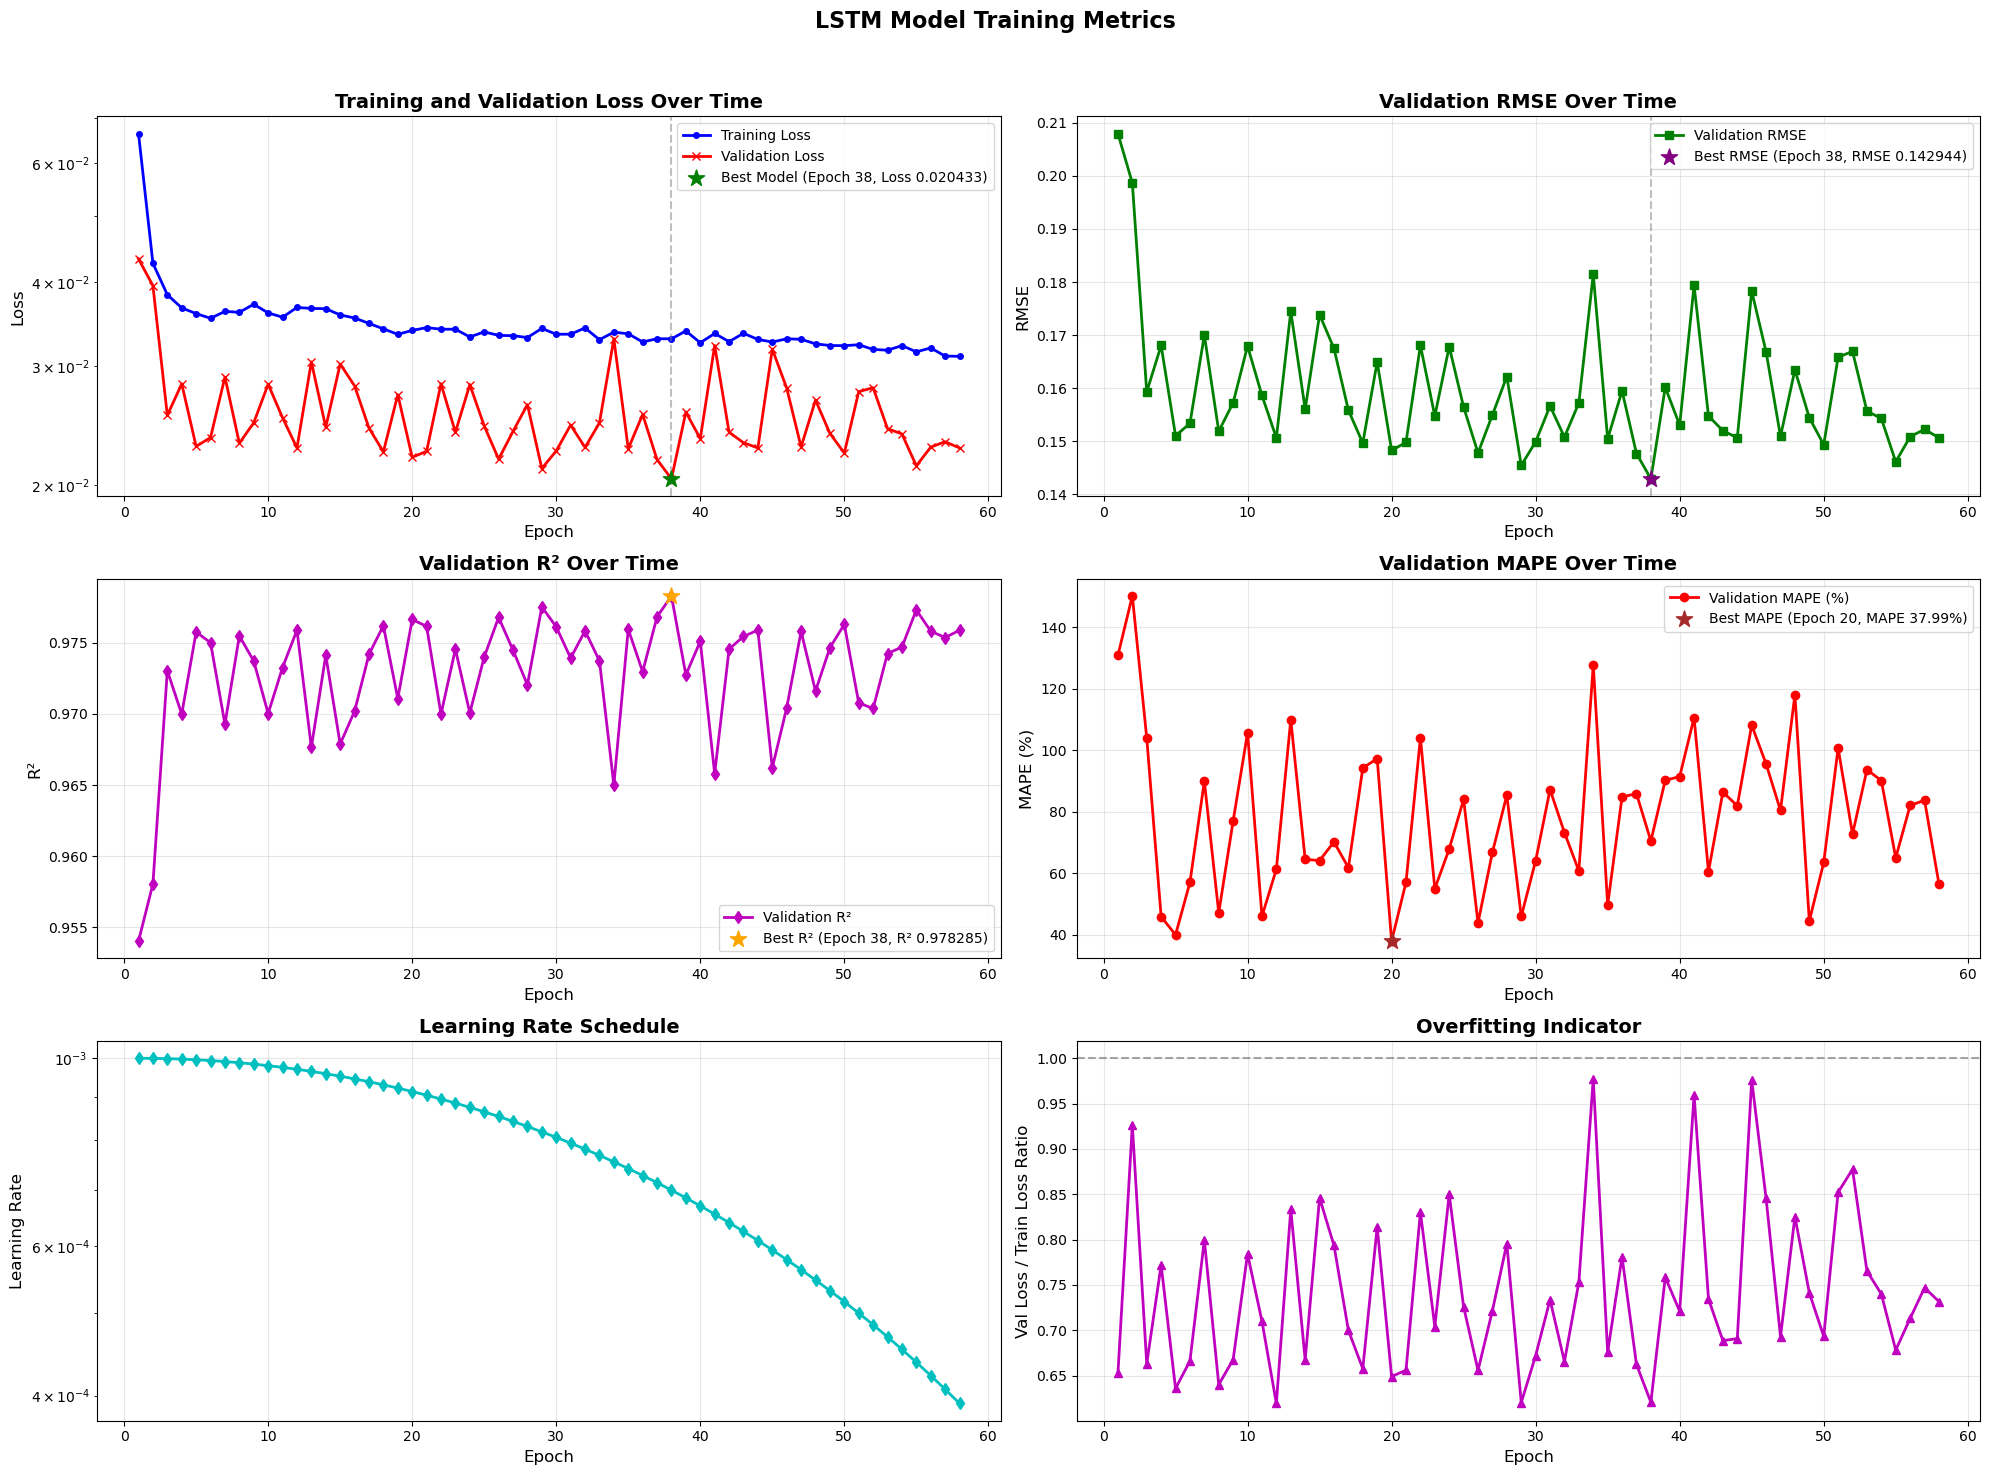

In [21]:
# Visualize training metrics
fig = model.plot_training_history()
plt.show()
model.transform_info = combined_transform_info  # Store the whole transform_info object

In [22]:
# Evaluate on test data
predictions, actuals, metrics = model.evaluate(
    X_test, y_test,
    target_scaler=scalers["Radiation_log1p"], # Use the log1p key
    transform_info=combined_transform_info,
)
    
# Calculate RMSE in original scale
rmse = np.sqrt(np.mean((predictions - actuals) ** 2))
#print(f"Test RMSE (original scale): {rmse:.4f}")
    


Scaled Metrics:
Test RMSE: 0.347242
Test R²: 0.869207
Test MAPE (capped at 100%): 38.34%

Original Scale Metrics:
Test RMSE: 0.868418
Test R²: 0.869207
Test MAPE (capped at 100%): 55.04%


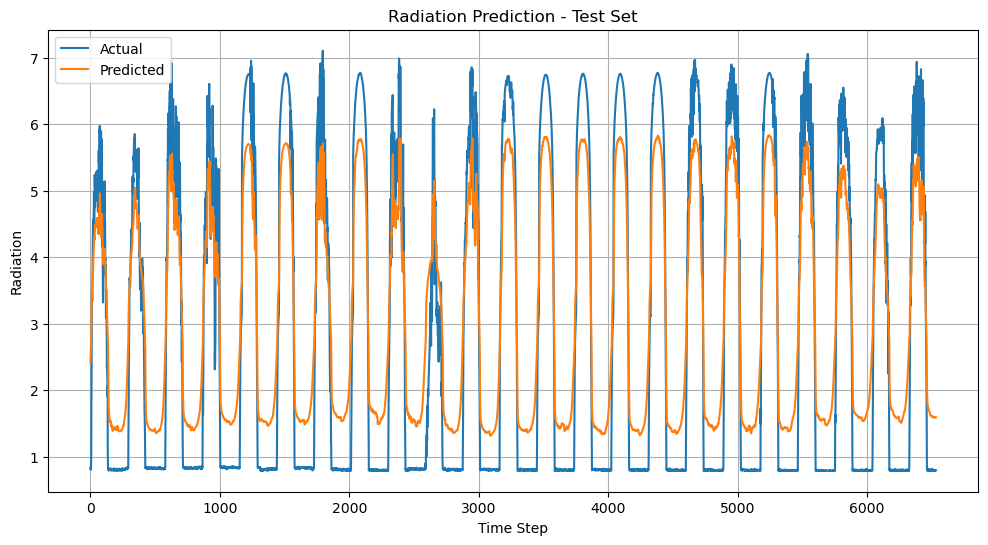

In [23]:
#plot predictions

plt.figure(figsize=(12, 6))
plt.plot(actuals, label='Actual')
plt.plot(predictions, label='Predicted')
plt.title('Radiation Prediction - Test Set')
plt.xlabel('Time Step')
plt.ylabel('Radiation')
plt.legend()
plt.grid(True)
plt.show()

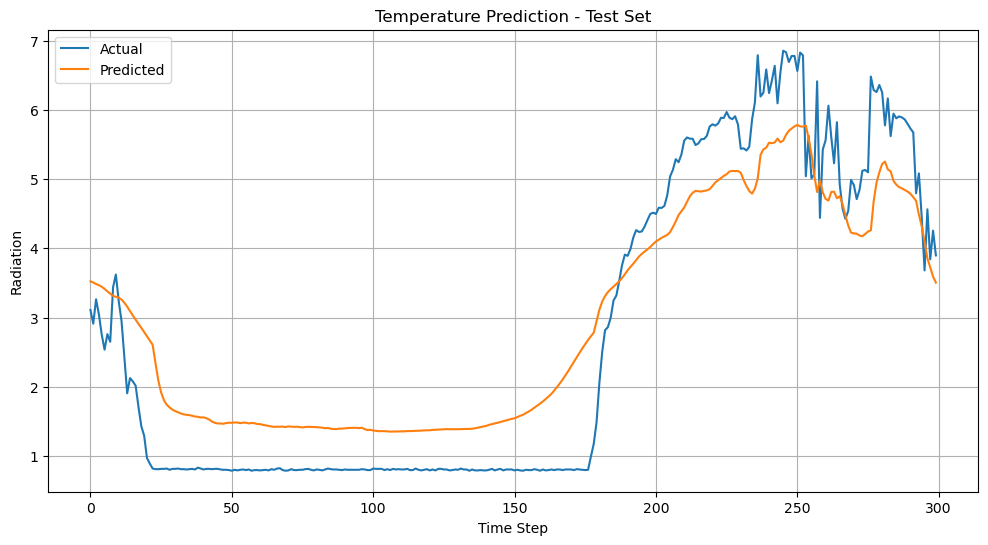

In [24]:
plt.figure(figsize=(12, 6))
plt.plot(actuals[2700:3000], label='Actual')
plt.plot(predictions[2700:3000], label='Predicted')
plt.title('Temperature Prediction - Test Set')
plt.xlabel('Time Step')
plt.ylabel('Radiation')
plt.legend()
plt.grid(True)
plt.show()

Resampling data to 1min frequency...
Original data points: 6533, After resampling: 6533
Evaluation Summary:
Number of samples (after resampling): 6533
RMSE: 0.851324
MAE: 0.770118
MAPE: 64.44%
R²: 0.874305
Correlation: 0.979516


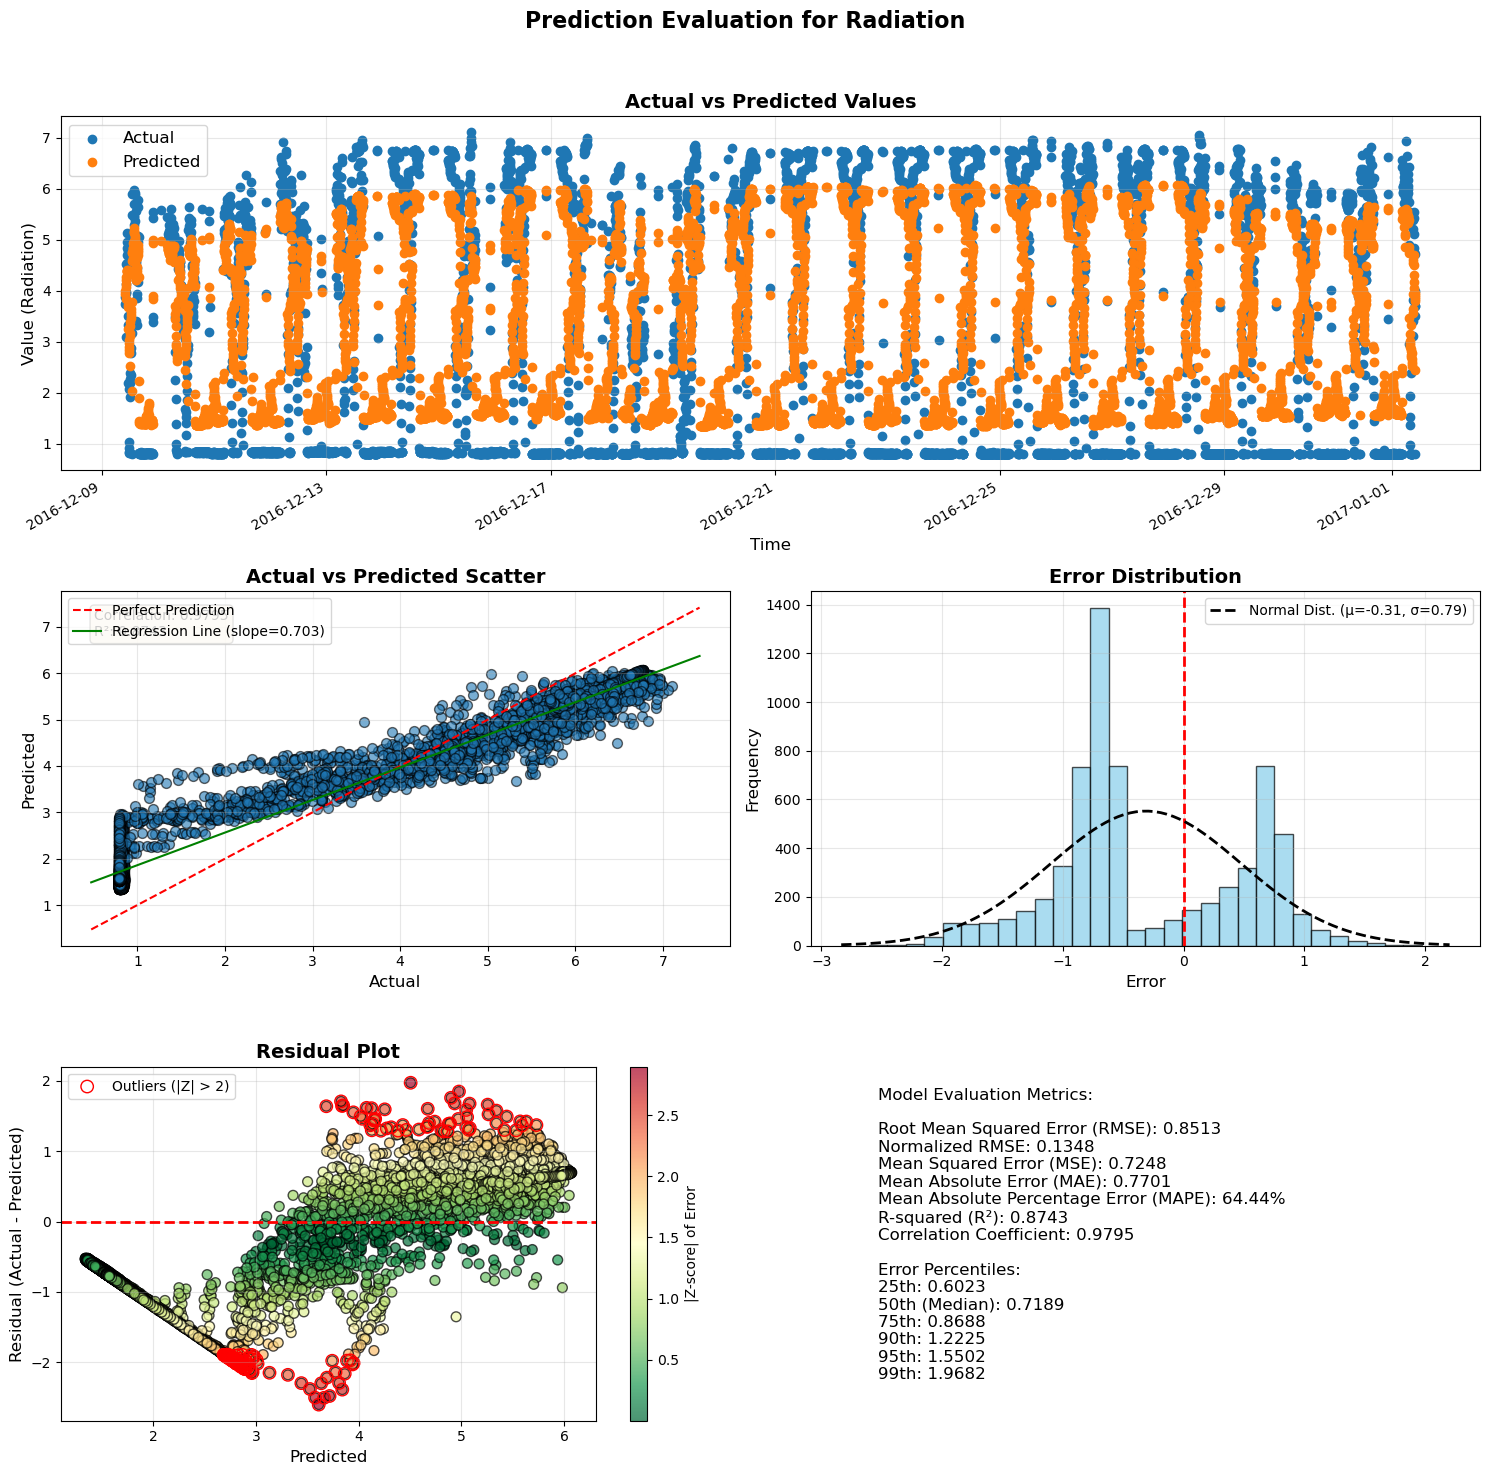

In [16]:
import plot_utils as pu 

# You can create timestamps if your data has a time component
timestamps = df['UNIXTime'].values[-len(predictions):]  # assuming UNIXTime exists in your df

# Make sure scaler is a dictionary with target_col as key
if not isinstance(scalers, dict):
    scalers_dict = {target_col: scalers}
else:
    scalers_dict = scalers

fig_eval = pu.create_evaluation_dashboard(
    predictions=predictions, 
    actuals=actuals, 
    scalers=None,  # !!! there is a bug here
    target_col=target_col,
    timestamps=timestamps
)




## Key Performance Metrics
- **RMSE: 69.7374**
- **Normalized RMSE: 0.0575** (excellent - below 0.1 indicates strong fit)
- **MAE: 33.1875**
- **MAPE: 37.98%**
- **R²: 0.9310**
- **Correlation Coefficient: 0.9656**

## Error Distribution Analysis

The error percentiles reveal a fascinating pattern:

| Percentile | Error Value |
|------------|-------------|
| 25th       | 0.0217      |
| 50th (Median) | 0.0817   |
| 75th       | 46.7872     |
| 90th       | 99.8823     |
| 95th       | 143.1077    |
| 99th       | 293.8402    |

## Insights

1. **Excellent Median Performance**: The median error of only 0.0817 indicates that at least 50% of the predictions are extremely accurate.

2. **Right-Skewed Error Distribution**: The dramatic jump between the 50th percentile (0.0817) and the 75th percentile (46.7872) reveals a highly skewed error distribution.

3. **Targeted Improvement Opportunity**: The large gap between percentiles suggests that the model is highly accurate for most cases but struggles significantly with a specific subset of observations.

4. **Performance Dichotomy**: The excellent normalized RMSE (0.0575) and R² (0.93) alongside the higher MAPE (37.98%) confirm that the model generally performs well but likely struggles with smaller radiation values where small absolute errors translate to large percentage errors.


In [17]:
model.save('weather_lstm_model.pt')

Model saved to weather_lstm_model.pt


# Weather Prediction LSTM Model: Technical Summary

## Model Architecture

**WeatherLSTM Network Structure:**<br>
┌─────────────────────────────────────────────────────┐<br>
│ ➤ LSTM Layer (16→256, layers=2, dropout=0.3)        │<br>
│ ➤ Dropout Layer (p=0.3)                             │<br>
│ ➤ Fully Connected Layer (256→128)                   │<br>
│ ➤ ReLU Activation                                   │<br>
│ ➤ Dropout Layer (p=0.3)                             │<br>
│ ➤ Fully Connected Layer (128→64)                    │<br>
│ ➤ ReLU Activation                                   │<br>
│ ➤ Dropout Layer (p=0.3)                             │<br>
│ ➤ Fully Connected Layer (64→1)                      │<br>
└─────────────────────────────────────────────────────┘

## Core Parameters
- **Input Dimension**: 16 features
- **Hidden Dimension**: 256 (increased from 64)
- **LSTM Layers**: 2
- **Output Dimension**: 1 (predicting a single value)
- **Dropout Probability**: 0.3 (applied at multiple layers)
- **Fully Connected Layers**: 256→128→64→1 with ReLU activations

## Dataset Structure
- **Training Set**: X_train shape: (19596, 24, 16), y_train shape: (19596, 1)
- **Validation Set**: X_val shape: (6533, 24, 16), y_val shape: (6533, 1)
- **Data Format**: 24 timesteps with 16 features per timestep

## Loss Function
The model uses a combined loss function:

$\mathcal{L}_{combined} = 0.7 \times \mathcal{L}_{MSE} + 0.3 \times \mathcal{L}_{MAPE}$

Where:
- $\mathcal{L}_{MSE} = \frac{1}{n}\sum_{i=1}^{n}(y_{true} - y_{pred})^2$
- $\mathcal{L}_{MAPE} = \frac{1}{n}\sum_{i=1}^{n}\left|\frac{y_{true} - y_{pred}}{|y_{true}| + \epsilon}\right| \times 100\%$
  - With $\epsilon = 1.0$ to protect against division by zero

## Regularization Techniques
- **Dropout**: Probability of 0.3 at LSTM and after each fully connected layer
- **L2 Regularization**: Weight decay of 0.0001
- **Gradient Clipping**: Norm constrained to 1.0

## Optimization Strategy
- **Learning Rate Scheduler**: CosineAnnealingLR with T_max=100
- **Patience for Early Stopping**: 15 epochs

## Data Transformation
- **Log Transformation**: Applied to Radiation values
  - $Radiation_{log} = \log(Radiation + \epsilon)$
  - Where $\epsilon$ is a small constant (1e-06) to prevent log(0)
- **Feature Engineering**: Added 'Radiation_is_low' binary feature (threshold: 1.2)

## Input Features
16 features including:
- Raw measurements: Radiation, Temperature, Pressure, Humidity, Wind Direction, Speed
- Engineered features: Radiation_is_low, SunriseMinutes, SunsetMinutes, DaylightMinutes
- Temporal features: TimeSinceSunrise, TimeUntilSunset, DaylightPosition
- Cyclical time encoding: TimeMinutesSin, TimeMinutesCos, HourOfDay

This architecture optimally balances model complexity with regularization to prevent overfitting while capturing the temporal patterns in weather data for accurate radiation prediction.